In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [4]:
# データの読み込みと確認
dat = pd.read_csv(r"C:\Users\sk062\Downloads\dat_with_country_all.csv")
print(dat.head(20))
print(dat.tail(20))

    energy    tempo  danceability playlist_genre  loudness  liveness  valence  \
0   0.7460  132.310         0.636           rock    -3.785    0.1730   0.4320   
1   0.8350  129.981         0.572           rock    -6.219    0.0702   0.7950   
2   0.8040  111.457         0.591           rock    -7.299    0.0818   0.6580   
3   0.1040   76.474         0.443           jazz   -17.042    0.1910   0.3940   
4   0.4720   80.487         0.685           jazz    -9.691    0.2240   0.4750   
5   0.3650  119.347         0.670           jazz   -10.158    0.0575   0.4500   
6   0.2640  122.482         0.663           jazz   -14.571    0.1000   0.6570   
7   0.2220  156.364         0.525           jazz   -11.065    0.0510   0.6450   
8   0.0619   60.705         0.336           jazz   -20.494    0.1100   0.1970   
9   0.6710  127.359         0.742           jazz    -8.142    0.1220   0.5910   
10  0.0422  130.436         0.519           jazz   -10.778    0.1240   0.3970   
11  0.1130   95.063         

In [6]:
# 欠損値の除去
dat = dat.dropna(subset=['popularity', 'energy'])

# 人気をカテゴリカル→数値へ変換
dat['pop'] = pd.Categorical(dat['popularity'], categories=['low', 'high'])
dat['ybin'] = (dat['pop'] == 'high').astype(int)

# ベクトル作成
y = dat['ybin'].values                  # 0/1の目的変数
x = dat['energy'].values               # 説明変数
X = np.column_stack((np.ones(len(x)), x))  # デザイン行列
n = len(y)

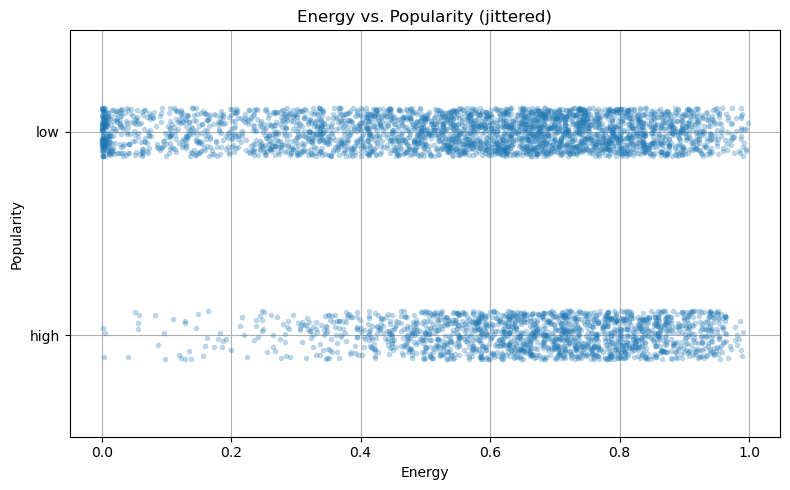

In [7]:
plt.figure(figsize=(8, 5))
sns.stripplot(x='energy', y='pop', data=dat, jitter=0.12, alpha=0.3, size=4)
plt.title("Energy vs. Popularity (jittered)")
plt.xlabel("Energy")
plt.ylabel("Popularity")
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
# statsmodelsでGLM
model = sm.GLM(dat['ybin'], X, family=sm.families.Binomial())
fit_glm = model.fit()
print(fit_glm.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                   ybin   No. Observations:                 4785
Model:                            GLM   Df Residuals:                     4783
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2953.2
Date:                Fri, 20 Jun 2025   Deviance:                       5906.3
Time:                        09:57:05   Pearson chi2:                 4.70e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.06147
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.0249      0.095    -21.242      0.0

In [9]:
b = np.array([np.log(np.mean(y) / (1 - np.mean(y))), 0.0])  # 初期値（切片のみ）
eps = 1e-8
maxit = 100

for k in range(maxit):
    eta = X @ b
    mu = 1 / (1 + np.exp(-eta))
    w = mu * (1 - mu)
    z = eta + (y - mu) / w

    sqrtw = np.sqrt(w)
    Xw = X * sqrtw[:, np.newaxis]
    zw = z * sqrtw
    XtWX = Xw.T @ Xw
    XtWz = Xw.T @ zw

    b_new = np.linalg.solve(XtWX, XtWz)

    print(f"Iter {k+1:2d} : β0 = {b_new[0]:.6f} , β1 = {b_new[1]:.6f}")

    if np.max(np.abs(b_new - b)) < eps:
        print(">>> 収束 <<<")
        break
    b = b_new

beta_hat = b_new
vcov_hat = np.linalg.inv(XtWX)
se_hat = np.sqrt(np.diag(vcov_hat))


Iter  1 : β0 = -1.819314 , β1 = 2.066695
Iter  2 : β0 = -2.016670 , β1 = 2.315923
Iter  3 : β0 = -2.024888 , β1 = 2.326903
Iter  4 : β0 = -2.024902 , β1 = 2.326921
Iter  5 : β0 = -2.024902 , β1 = 2.326921
>>> 収束 <<<


In [10]:
# GLM係数とSE
glm_coef = fit_glm.params.values
glm_se = np.sqrt(np.diag(fit_glm.cov_params()))

print("\n=== Coefficient Comparison ===")
print(pd.DataFrame({
    "Hand_IRLS": beta_hat,
    "GLM": glm_coef
}, index=["Intercept", "Energy"]))

print("\n=== SE Comparison ===")
print(pd.DataFrame({
    "Hand_IRLS": se_hat,
    "GLM": glm_se
}, index=["Intercept", "Energy"]))



=== Coefficient Comparison ===
           Hand_IRLS       GLM
Intercept  -2.024902 -2.024902
Energy      2.326921  2.326921

=== SE Comparison ===
           Hand_IRLS       GLM
Intercept   0.095325  0.095325
Energy      0.142537  0.142537


In [13]:
list(dat.columns)

['energy',
 'tempo',
 'danceability',
 'playlist_genre',
 'loudness',
 'liveness',
 'valence',
 'track_artist',
 'time_signature',
 'speechiness',
 'track_popularity',
 'track_href',
 'uri',
 'track_album_name',
 'playlist_name',
 'analysis_url',
 'track_id',
 'track_name',
 'track_album_release_date',
 'instrumentalness',
 'track_album_id',
 'mode',
 'key',
 'duration_ms',
 'acousticness',
 'id',
 'playlist_subgenre',
 'type',
 'playlist_id',
 'popularity',
 'genre6',
 'country',
 'pop',
 'ybin']

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.special import expit  # sigmoid
import statsmodels.api as sm

# 例：必要なカラムだけ抽出
X_cols = ['energy', 'danceability', 'valence', 'loudness']
df = dat.dropna(subset=X_cols + ['ybin'])  # 欠損除去

# 標準化（オプション）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[X_cols])

# 定数項追加
X = sm.add_constant(X_scaled)
y = df['ybin'].astype(int)

# IRLSによるロジスティック回帰（statsmodelsが内部でIRLSを使う）
model = sm.Logit(y, X)
result = model.fit()

print(result.summary())


Optimization terminated successfully.
         Current function value: 0.595390
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                   ybin   No. Observations:                 4785
Model:                          Logit   Df Residuals:                     4780
Method:                           MLE   Df Model:                            4
Date:                Fri, 20 Jun 2025   Pseudo R-squ.:                 0.08245
Time:                        10:15:30   Log-Likelihood:                -2848.9
converged:                       True   LL-Null:                       -3104.9
Covariance Type:            nonrobust   LLR p-value:                1.708e-109
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8122      0.038    -21.533      0.000      -0.886      -0.738
x1            -0.0977      0.

In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# === データの準備 ===
X_raw = df[X_cols].values
y = df['ybin'].values.reshape(-1, 1)

# 標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

# 切片項を追加
X = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])
n, d = X.shape

# === IRLS 実装 ===
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def IRLS(X, y, max_iter=100, tol=1e-6):
    beta = np.zeros((X.shape[1], 1))
    
    for i in range(max_iter):
        z = X @ beta
        p = sigmoid(z)
        W = np.diagflat(p * (1 - p))
        try:
            # 疑似目的変数 z_tilde
            z_tilde = z + np.linalg.pinv(W) @ (y - p)
            # IRLS update
            beta_new = np.linalg.pinv(X.T @ W @ X) @ (X.T @ W @ z_tilde)
        except np.linalg.LinAlgError:
            print("数値計算でエラーが発生しました（特異行列）")
            break
        
        # 収束判定
        if np.linalg.norm(beta_new - beta) < tol:
            print(f"収束しました（{i+1}回目）")
            break
        
        beta = beta_new
        
    return beta

# モデル学習
beta_hat = IRLS(X, y)

# 結果表示
feature_names = ['Intercept'] + X_cols
for name, coef in zip(feature_names, beta_hat.flatten()):
    print(f"{name:>12}: {coef:.4f}")


収束しました（6回目）
   Intercept: -0.8122
      energy: -0.0977
danceability: -0.0854
     valence: 0.0002
    loudness: 1.2838
